In [47]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(scater)
    library(ComplexHeatmap)
})

In [19]:
infercnv_obj <- readRDS("./out_inferCNV/hepatoctyes_sd1.75_NULL_subclusters/run.final.infercnv_obj")
gene_order <- readr::read_tsv("./data_for_run/gencode.v22.annotation.virus.gene_pos.tsv", col_names = F)
gene_info <- readr::read_tsv("../../data/metadata/featurecounts_gene_info.tsv")
gene_info$GENEID <- sapply(strsplit(gene_info$GENEID, "\\."), `[[`, 1)
colnames(gene_order) <- c("geneId", "chrom", "start", "end")
gene_order <- dplyr::left_join(gene_order, gene_info[, c("GENEID", "SYMBOL")], by = c("geneId" = "GENEID") )
gene_order <- as.data.frame(gene_order)
rownames(gene_order) <- scater::uniquifyFeatureNames(ID = gene_order$geneId, names = gene_order$SYMBOL)
gene_order <- gene_order[rownames(mt_obs),]
gr <- GenomicRanges::GRanges(gene_order)
mt_obs <- infercnv_obj@expr.data


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_double(),
  X4 = col_double()
)



── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  SYMBOL = col_character(),
  GENEID = col_character(),
  CHR = col_character(),
  START = col_double(),
  END = col_double(),
  BIOTYPE = col_character()
)




In [37]:
fns <- list.files("../../data/pipeline_output/cnvkit/HCC_tumor", pattern = "*.call.cns", full.names = T)


In [39]:
# functions
read_cns <- function(fn) {
    df <- readr::read_tsv(fn)
    df <- df[, c("chromosome", "start", "end", "log2")]
    gr_cnv <- GRanges(df)
    shit <- subjectHits(findOverlaps(gr, gr_cnv))
    qhit <- queryHits(findOverlaps(gr, gr_cnv))
    gr_cnv_mt <- gr_cnv[shit]
    gr_cnv_mt$qhit <- qhit
    gr_cnv_mt <- as.data.frame(gr_cnv_mt)
    gr_cnv_log2 <- gr_cnv_mt %>% 
        group_by(qhit) %>%
        summarise(log2 = mean(log2)) 
    gr_cnv_log2$geneid <- rownames(mt_obs)
    gr_cnv_log2 <- gr_cnv_log2[, c('geneid', 'log2')]
    mt <- as.matrix(gr_cnv_log2[, 'log2', drop = F])
    rownames(mt) <- gr_cnv_log2$geneid
    colnames(mt) <- fn
    mt
}
# Read CNVKit
mt_cnv <- do.call(cbind, lapply(fns, read_cns))


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  chromosome = col_character(),
  start = col_double(),
  end = col_double(),
  gene = col_character(),
  log2 = col_double(),
  cn = col_double(),
  depth = col_double(),
  p_ttest = col_double(),
  probes = col_double(),
  weight = col_double()
)


`summarise()` ungrouping output (override with `.groups` argument)


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  chromosome = col_character(),
  start = col_double(),
  end = col_double(),
  gene = col_character(),
  log2 = col_double(),
  cn = col_double(),
  depth = col_double(),
  p_ttest = col_double(),
  probes = col_double(),
  weight = col_double()
)


`summarise()` ungrouping output (override with `.groups` argument)


── Column specification ───────

In [41]:
colnames(mt_cnv) <- sapply(strsplit(colnames(mt_cnv), '\\/'), `[[`, 7)
colnames(mt_cnv) <- gsub("PE1[GZ]_ZZM_", "", colnames(mt_cnv))
colnames(mt_cnv) <- gsub("marked_dup.call.cns", "", colnames(mt_cnv))
colnames(mt_cnv) <- gsub("-DNA.", "", colnames(mt_cnv))
colnames(mt_cnv) <- gsub("\\.$", "", colnames(mt_cnv))
colnames(mt_cnv) <- paste0("D", colnames(mt_cnv))

In [43]:
mt_cnv <- mt_cnv[, c("D20170327-tumor", "D20170412-tumor", "D20171109-tumor", "D20171220-tumor","D20180108-tumor", "D20180108-tumor-center",
           "D20180110-tumor", "D20180110-TC")]

In [44]:
mt_cnv <- mt_cnv[, c("D20180110-tumor", "D20180110-TC","D20171220-tumor", "D20170327-tumor","D20180108-tumor","D20180108-tumor-center",
                     "D20170412-tumor", "D20171109-tumor")]

In [45]:
colnames(mt_cnv) <- c("(Tumor Core) D20180110", " (Tumor Edge) D20180110",
                      "(Tumor) D20171220", 
                      "(Tumor) D20170327",
                      "(Tumor Edge) D20180108",
                      "(Tumor Core) D20180108",
                      "(Tumor) D20170412", 
                      "(Tumor) D20171109")

In [53]:
exome_info <- data.frame(donor = str_extract(colnames(mt_cnv), pattern = "D.+$"), 
                        tissue = sapply(strsplit(colnames(mt_cnv), " "), `[[`, 2),
                        celltype_analysis = 'WES',
                        reference = 'WES', stringsAsFactors = F)
exome_info$tissue <- gsub("\\(|\\)","", str_extract(colnames(mt_cnv), pattern = "\\(.+\\)"))
gene_order$chr <- factor(gene_order$chrom, levels = paste0("chr", 1:22))
gene_order <- gene_order[order(gene_order$chr),]
mt_cnv <- mt_cnv[order(gene_order$chr),]

In [54]:
exome_info

donor,tissue,celltype_analysis,reference
<chr>,<chr>,<chr>,<chr>
D20180110,Tumor Core,WES,WES
D20180110,Tumor Edge,WES,WES
D20171220,Tumor,WES,WES
D20170327,Tumor,WES,WES
D20180108,Tumor Edge,WES,WES
D20180108,Tumor Core,WES,WES
D20170412,Tumor,WES,WES
D20171109,Tumor,WES,WES


In [64]:
mt_cnv[1:4, 1:4]

,(Tumor Core) D20180110,(Tumor Edge) D20180110,(Tumor) D20171220,(Tumor) D20170327
FO538757.2,0.0470722,0.201229,0.491023,-0.30726
SAMD11,0.0470722,0.049216,-0.480503,-0.30726
NOC2L,0.0470722,-0.102797,-0.480503,-0.30726
KLHL17,0.0470722,-0.102797,-0.480503,-0.30726


In [63]:
mt[1:5, 1:4]

,FO538757.2,SAMD11,NOC2L,KLHL17
(Tumor Core) D20180110,0.0470722,0.0470722,0.0470722,0.0470722
(Tumor Edge) D20180110,0.2012290,0.0492160,-0.1027970,-0.1027970
(Tumor) D20171220,0.4910230,-0.4805030,-0.4805030,-0.4805030
(Tumor) D20170327,-0.3072600,-0.3072600,-0.3072600,-0.3072600
(Tumor Edge) D20180108,0.0971427,0.0971427,0.0971427,0.0971427


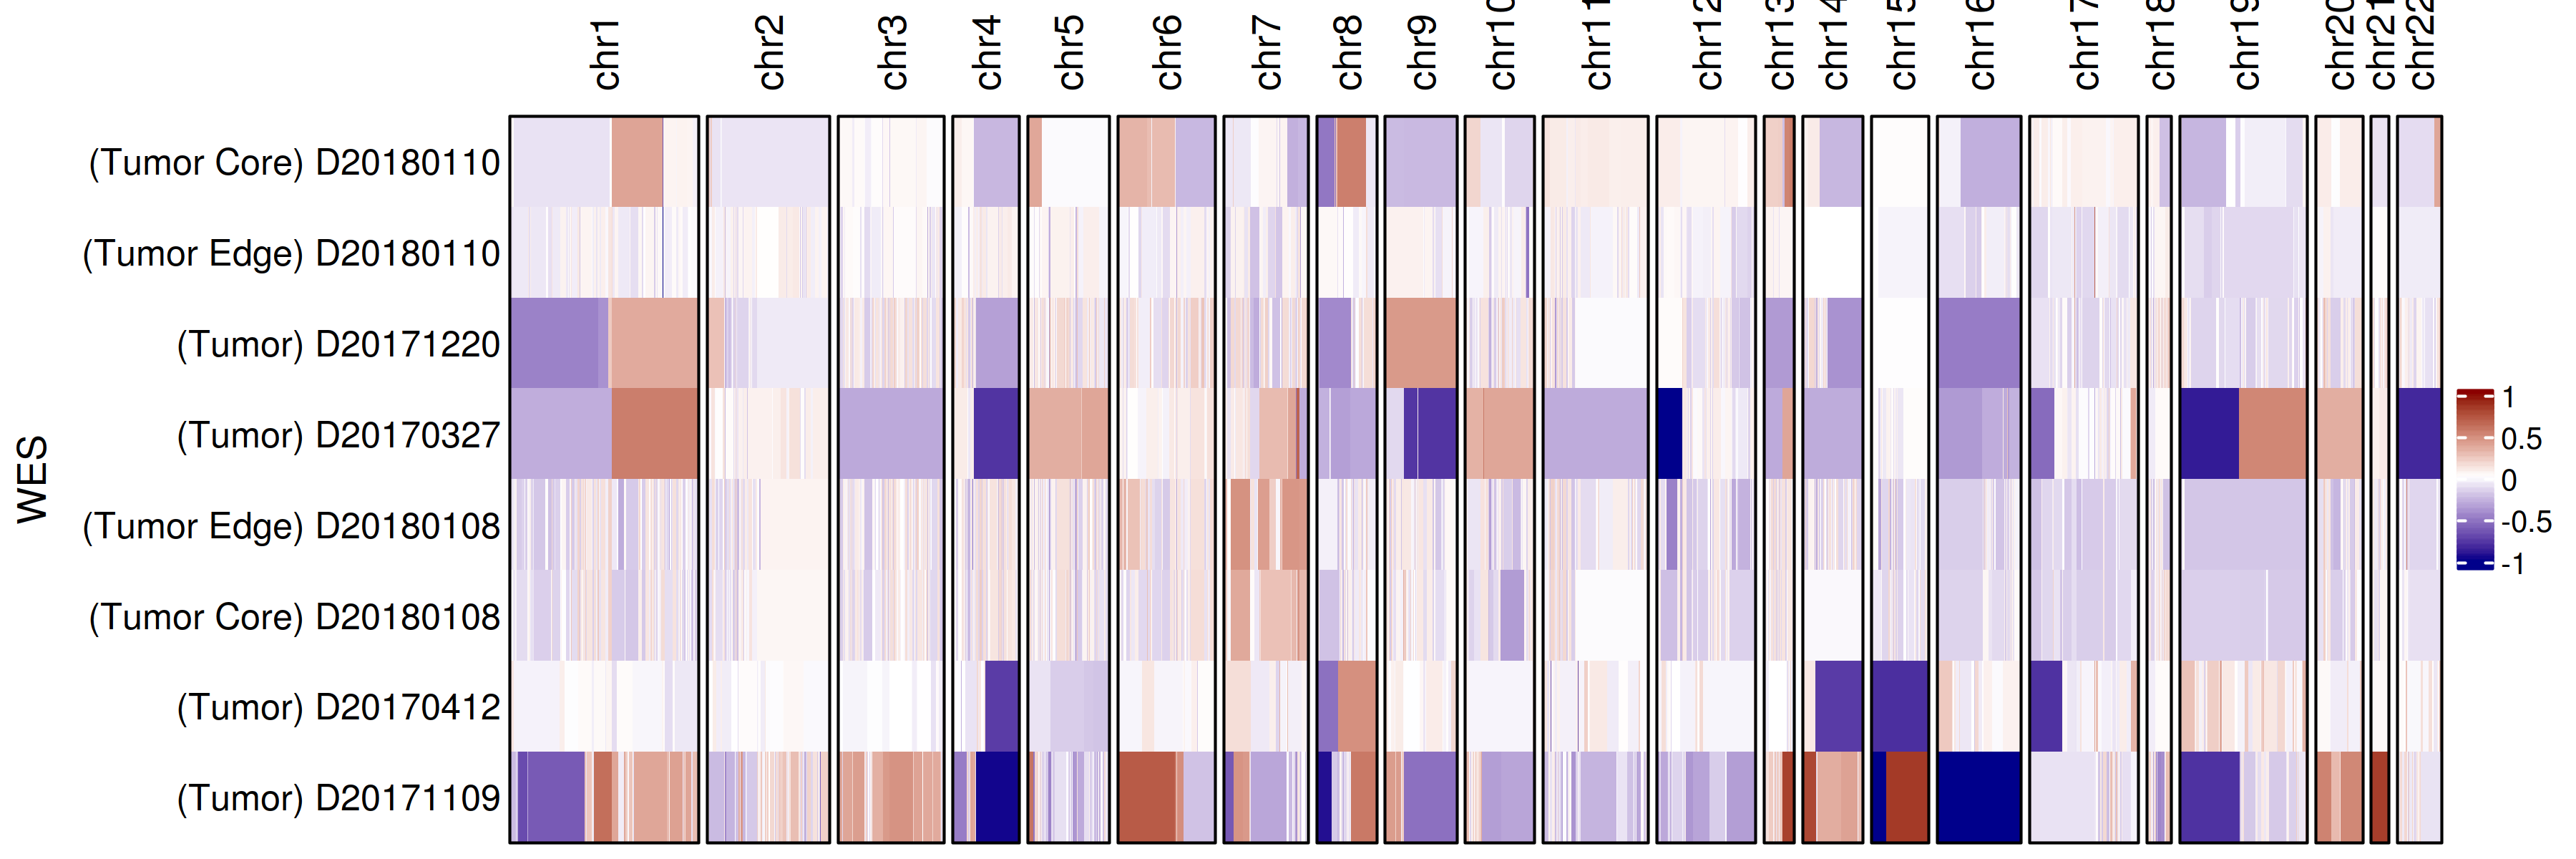

In [65]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 300)

col_fun <- circlize::colorRamp2(c(-1, 0, 1), c("darkblue", "white", "darkred"))

mt <- t(mt_cnv)
#mt <- mt - rowMeans(mt)
#mt[mt > 1] = 1
#mt[mt < -1] = -1
ht <- Heatmap(mt,  col = col_fun, heatmap_legend_param = list(title = ""), cluster_rows = FALSE, cluster_columns = FALSE, row_names_side = "left",
              clustering_method_columns = 'ward.D2', show_column_names = F, show_row_names = T, column_title_rot = 90, 
              column_split = gene_order$chr, row_split = exome_info$reference, border = TRUE)
draw(ht)

### RNA

In [12]:
mt_rna <- read.table("/mnt/d/Projects/scHCC-tumor/analyses/inferCNV/output_dir_bulkHCC/infercnv.observations.txt")

In [13]:
ov_genes <- intersect(rownames(mt_cnv), rownames(mt_rna))

In [14]:
mt_cnv <- mt_cnv[ov_genes,]
mt_rna <- mt_rna[ov_genes,]

In [15]:
mt_rna <- mt_rna[, c('D20180110.tumor', 'D20180110.TC', 'D20171220.tumor', 'D20170322.tumor', 'D20180108.tumor','D20180108.TC', 'D20170412.tumor','D20171109.T')]

In [17]:
colnames(mt_rna) <- c('D20180110 (Tumor Core)', 
                      'D20180110 (Tumor Edge)', 
                      'D20171220 (Tumor)', 
                      'D20170322 (Tumor)', 
                      'D20180108 (Tumor Edge)',
                      'D20180108 (Tumor Core)', 
                      'D20170412 (Tumor)',
                      'D20171109 (Tumor)')

In [18]:
gene_order <- gene_order[ov_genes,]

In [20]:

#exome_info[which(exome_info$tissue == 'TC'), "tissue"] <- 'TumorCore'
#exome_info[which(exome_info$tissue == 'T'), "tissue"] <- 'Tumor'
#exome_info[which(exome_info$tissue == 'tumor'), "tissue"] <- 'Tumor'


In [25]:
exome_info$tissue <- gsub("\\(|\\)","", str_extract(colnames(mt_rna), pattern = "\\(.+\\)"))

In [26]:
rna_info <- data.frame(donor = sapply(strsplit(colnames(mt_cnv), " "), `[[`, 1), 
                        tissue = sapply(strsplit(colnames(mt_cnv), " "), `[[`, 2), 
                       celltype_analysis = 'bulkRNA',
                       reference = 'bulkRNA',
                       stringsAsFactors = F)
rna_info$tissue <- gsub("\\(|\\)","", str_extract(colnames(mt_rna), pattern = "\\(.+\\)"))
rownames(rna_info) <- colnames(mt_rna)


In [28]:
mt_bulk <- cbind(mt_cnv, mt_rna)
bulk_info <- rbind(exome_info, rna_info)
gene_order$chr <- factor(gene_order$chrom, levels = paste0("chr", 1:22))
gene_order <- gene_order[order(gene_order$chr),]
mt_bulk <- mt_bulk[order(gene_order$chr),]

In [33]:
library(ComplexHeatmap)
ha = HeatmapAnnotation(df = bulk_info)
#mt = mt - rowMeans(mt)
col_fun <- circlize::colorRamp2(c(-1, 0, 1), c("darkblue", "white", "darkred"))
mt <- t(mt_bulk)
mt <- mt - rowMeans(mt)
mt[mt > 1] = 1
mt[mt < -1] = -1
ht <- Heatmap(mt, col = col_fun,   heatmap_legend_param = list(title = ""), cluster_rows = FALSE, cluster_columns = FALSE, row_names_side = "left",
              clustering_method_columns = 'ward.D2', show_column_names = F, show_row_names = T, column_title_rot = 90, 
              column_split = gene_order$chr, row_split = bulk_info$reference, border = TRUE)

pdf("./figures/heatmap_inferCNV_WES_and_bulkRNA_modified.pdf", width = 24, height = 3)
draw(ht)
dev.off()

png 
  2

### Visualize

In [14]:
BASE_DIR = '/mnt/d/Projects/scHCC-tumor'
sce = readRDS(file.path(BASE_DIR, 
                     "data/processed/anndata/20200308/anndata_SmartSeq2_CD45_QC_Global_NonImmune_ForDownstreamAnalysis.rds"))

In [15]:
colnames(mt_obs) <- gsub("\\.", "-", colnames(mt_obs))

In [16]:
library(scater)
coldata <- as.data.frame(colData(sce))

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: DelayedArray

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


The following object is masked from ‘package:dplyr’:

    count


Loading required package: BiocParallel


Attaching package: ‘DelayedArray’


The following objects are masked from ‘package:matrixStats’:

    colMaxs, colMins, colRanges, rowMaxs, rowMins, rowRanges


The following object is masked from ‘package:purrr’:

    simplify


The following objects are masked from ‘package:base’:

    aperm, apply, rowsum




In [17]:
coldata <- coldata[colnames(mt_obs), ]

In [18]:
coldata$reference <- ifelse(grepl("Hepa", coldata$celltype_analysis), "Normal", "Tumor")
coldata$donor <- factor(coldata$donor, levels = c("D20180110", "D20171220", "D20170327", "D20170322", "D20180108", "D20171215", "D20170412", 
                                                  "D20171109", "D20171229", "D20170227"))

In [19]:
coldata <- coldata[order(coldata$reference, coldata$donor, coldata$tissue, coldata$celltype_analysis),]

In [20]:
mt_obs <- mt_obs[, rownames(coldata)]

In [21]:
#gene_order <- gene_order[rownames(mt_obs),]
gene_order$chr <- factor(gene_order$chrom, levels = paste0("chr", 1:22))
gene_order <- gene_order[order(gene_order$chr),]

In [22]:
mt_obs <- mt_obs[order(gene_order$chr),]

In [23]:
cell_info <- coldata[, c("donor", "tissue", "celltype_analysis", "reference" )]

In [24]:
mt_cnv <- mt_cnv[rownames(mt_obs),]

In [25]:
exome_info <- data.frame(donor = sapply(strsplit(colnames(mt_cnv), "-"), `[[`, 1), 
                        tissue = sapply(strsplit(colnames(mt_cnv), "-"), `[[`, 2),
                        celltype_analysis = 'WES',
                        reference = 'WES', stringsAsFactors = F)
exome_info[which(exome_info$tissue == 'TC'), "tissue"] <- 'TumorCore'
exome_info[which(exome_info$tissue == 'T'), "tissue"] <- 'Tumor'
exome_info[which(exome_info$tissue == 'tumor'), "tissue"] <- 'Tumor'


In [26]:
mt_final <- cbind(mt_cnv, mt_obs)
mt_info <- rbind(cell_info, exome_info)

In [214]:
library(ComplexHeatmap)
ha = HeatmapAnnotation(df = mt_info)
#mt = mt - rowMeans(mt)
col_fun <- circlize::colorRamp2(c(-0.5, 0, 0.5), c("darkblue", "white", "darkred"))
mt <- t(mt_final)
mt <- mt - rowMeans(mt)
mt[mt > 1] = 1
mt[mt < -1] = -1
ht <- Heatmap(mt, col = col_fun,  cluster_rows = FALSE, cluster_columns = FALSE, 
              clustering_method_columns = 'ward.D2', show_column_names = F, show_row_names = F,  
              column_split = gene_order$chrom, row_split = mt_info$reference, border = TRUE) + 
rowAnnotation(df = mt_info) 

pdf("./figures/heatmap_inferCNV_hepatocytes_and_WES.pdf", width = 24, height = 9)
draw(ht)
dev.off()

png 
  2

[1] "D20170327-tumor"        "D20170412-tumor"        "D20171109-tumor"       
[4] "D20171220-tumor"        "D20180108-tumor"        "D20180108-tumor-center"
[7] "D20180110-tumor"        "D20180110-TC"

In [27]:
library(ComplexHeatmap)
ha = HeatmapAnnotation(df = exome_info)
#mt = mt - rowMeans(mt)
col_fun <- circlize::colorRamp2(c(-1, 0, 1), c("darkblue", "white", "darkred"))
mt <- t(mt_cnv)
mt <- mt - rowMeans(mt)
mt[mt > 1] = 1
mt[mt < -1] = -1
ht <- Heatmap(mt, col = col_fun,  cluster_rows = FALSE, cluster_columns = FALSE, 
              clustering_method_columns = 'ward.D2', show_column_names = F, show_row_names = T,  
              column_split = gene_order$chr, border = TRUE)

pdf("./figures/heatmap_inferCNV_WES.pdf", width = 24, height = 9)
draw(ht)
dev.off()

Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.




png 
  2